In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist, fashion_mnist
from keras.callbacks import TensorBoard, History
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# MNIST digit data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_train.shape)

(60000, 784) (60000,)
(10000, 784) (60000,)


In [3]:
print(type(x_test))

selected_samples = np.zeros(10)
l = []
i = 0
while len(l)<10:
    if y_test[i] not in l:
        l.append(y_test[i])
        selected_samples[y_test[i]] = int(i)
        i = i + 1
    else:
        i = i + 1
selected_samples = list(selected_samples)
selected_samples = [int(s) for s in selected_samples]

<class 'numpy.ndarray'>


In [2]:
def get_nmf_init_weights(layers=None):

    weight_matrix = []
    for i in range(len(layers)-2,-1, -1):
        nmf = NMF(n_components=layers[i+1], init='random', random_state=0)
        
        W = nmf.fit_transform(np.identity(layers[i]))
        H = nmf.components_
 
        weight_matrix.insert(0,W)
        weight_matrix.append(H)
    
    # add bias to the list of weights
    n_layers = len(weight_matrix)
    for i in range(n_layers):
        weight_matrix.insert(2*i+1, np.random.rand(weight_matrix[2*i].shape[1]))
        
    return weight_matrix



In [3]:
def build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)):
    
    if initializer!='nmf':
        input_img = Input(shape=(784,))
        encoded = Dense(128, activation='relu', kernel_initializer=initializer)(input_img)
        encoded = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
        encoded = Dense(32, activation='relu', kernel_initializer=initializer)(encoded)

        decoded = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
        decoded = Dense(128, activation='relu', kernel_initializer=initializer)(decoded)
        decoded = Dense(784, activation='sigmoid', kernel_initializer=initializer)(decoded)
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
        
    else:
        input_img = Input(shape=(784,))
        encoded = Dense(128, activation='relu')(input_img)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dense(32, activation='relu')(encoded)
        
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dense(784, activation='sigmoid')(decoded)
        
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)
    
        init_weights = get_nmf_init_weights([784, 128, 64, 32])
        autoencoder.set_weights(init_weights)
    
    autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.summary()
    
    return autoencoder



In [4]:
def display_images(x_test, decoded_imgs, selected_samples, image_type=[], name='reconstruction'):    
    n = len(selected_samples)  # how many digits we will display
    plt.figure(figsize=(14, 8))
    plt.title('Comparison of original and reconstructed image using different initialization methods')
    image_type = ['Original Image']+image_type
    for j in range(len(image_type)):
        ax = plt.subplot(len(image_type), n+2, (j*(n+2)+1))
        ax.text(0, 0.5, image_type[j], fontsize=16)
        ax.axis("off")
        
    for i in range(n):

        # display original
        ax = plt.subplot(len(image_type), n+2, i + 3)
        plt.imshow(x_test[selected_samples[i]].reshape(28, 28))
        plt.gray()
        ax.axis("off")

        for j in range(1,len(image_type)):
            # display reconstruction with different initialization
            ax = plt.subplot(len(image_type), n+2, i + 3 + (j)*(n+2))
            plt.imshow(decoded_imgs[image_type[j]][selected_samples[i]].reshape(28, 28))
            plt.gray()
            ax.axis("off")
    plt.tight_layout()        
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.savefig(name+'.png', dpi=200)
    plt.show()
    
    
def display_loss(hist, name, init_types=[]):
    for init_method in init_types:
        plt.plot(range(1,len(hist[init_method].history['val_loss'])+1),hist[init_method].history['val_loss'], label=init_method)
    plt.title('Loss drop for different initialization methods')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(name+'.png', dpi=200)
    plt.show()
    

In [5]:
methods = ['NMF', 'RandomNormal', 'GlorotNormal', 'HeNormal', 'VarianceScaling', 'Orthogonal']
small_sample_size = 3000

# Train using all samples, 50 epochs

Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


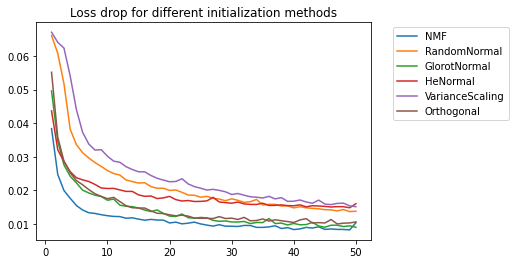

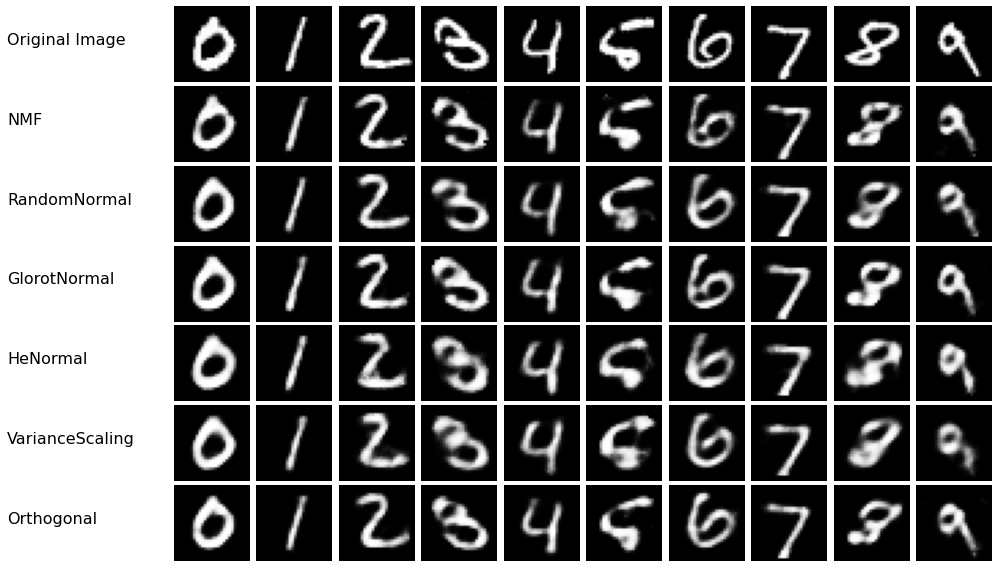

In [8]:
sample_size='all'
epochs = 50
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train, x_train,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_digit_loss_'+str(sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test)
    
display_images(x_test, decoded_imgs, selected_samples, image_type=methods, name='images/mnist_digit_reconstruction_'+str(sample_size)+'_'+str(epochs))

# Train using all samples, fewer epochs

Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


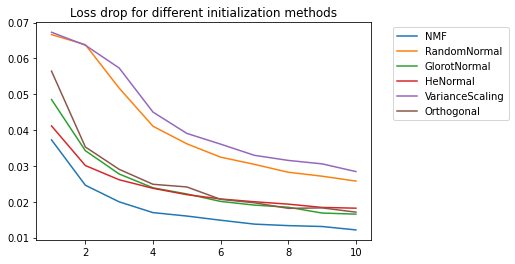

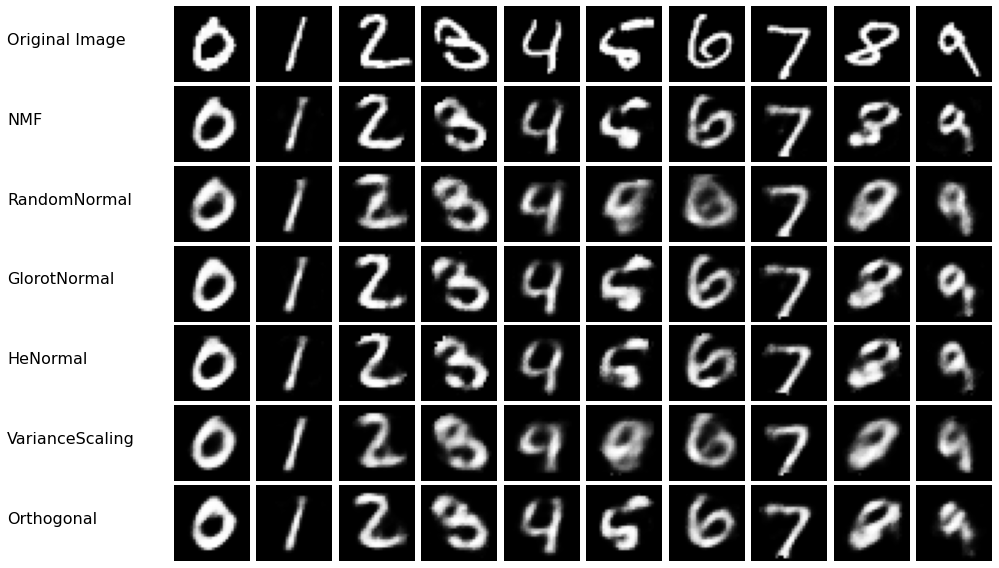

In [8]:
sample_size='all'
epochs = 10
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train, x_train,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_digit_loss_'+str(sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test)
    
display_images(x_test, decoded_imgs, selected_samples, image_type=methods, name='images/mnist_digit_reconstruction_'+str(sample_size)+'_'+str(epochs))

# Train using fewer samples, 50 epochs

In [8]:
x_train_small = x_train[:small_sample_size, :]
y_train_small = y_train[:small_sample_size]
print(Counter(y_train_small))

Counter({1: 339, 7: 329, 4: 325, 6: 306, 2: 299, 3: 295, 9: 287, 0: 285, 5: 274, 8: 261})


Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


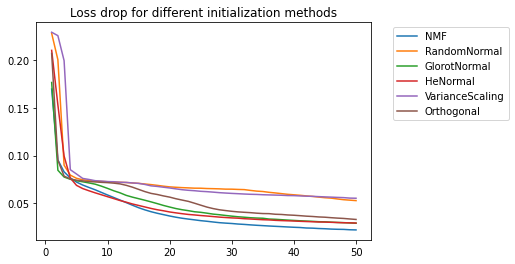

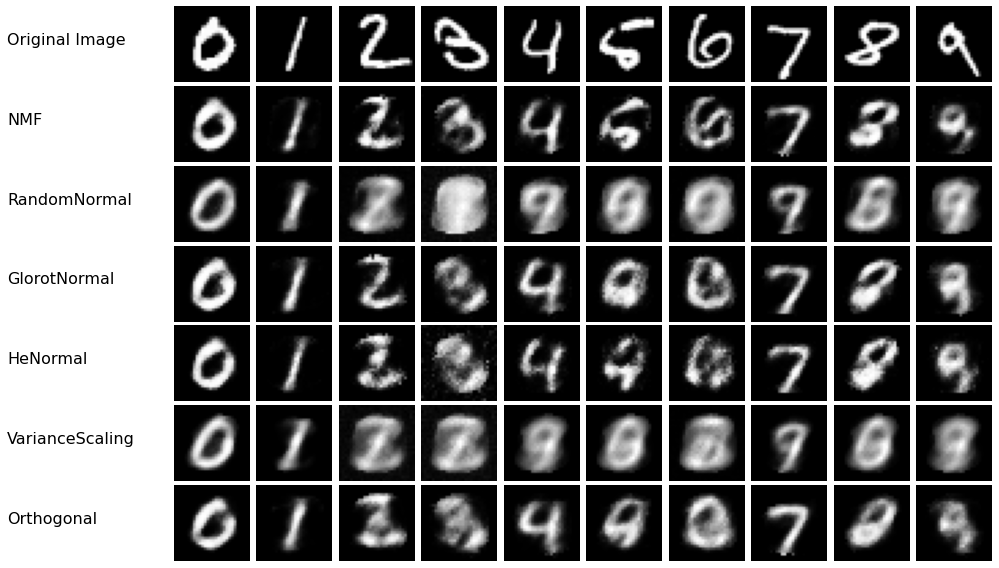

In [9]:
epochs = 50
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_small, x_train_small,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_digit_loss_'+str(small_sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test)
    
display_images(x_test, decoded_imgs, selected_samples, image_type=methods, name='images/mnist_digit_reconstruction_'+str(small_sample_size)+'_'+str(epochs))

# Train using fewer samples, fewer epochs

In [8]:
x_train_small = x_train[:small_sample_size, :]
y_train_small = y_train[:small_sample_size]
print(Counter(y_train_small))

Counter({1: 339, 7: 329, 4: 325, 6: 306, 2: 299, 3: 295, 9: 287, 0: 285, 5: 274, 8: 261})


Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


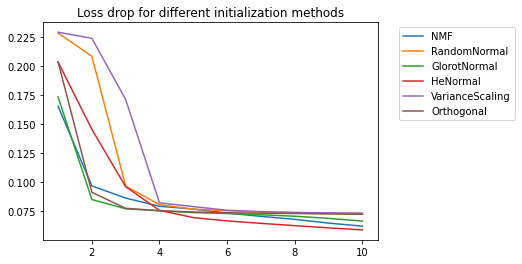

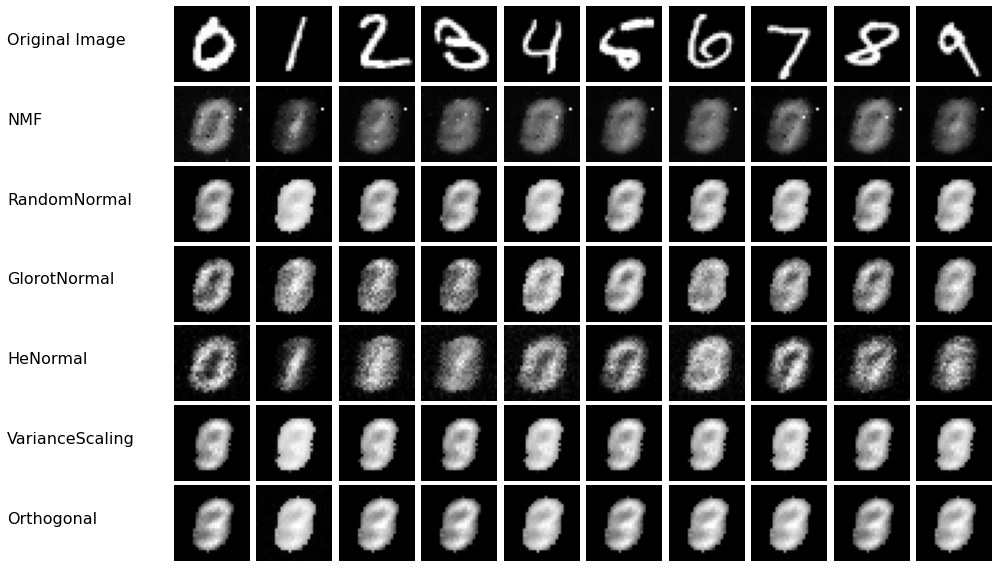

In [9]:
epochs = 10
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_small, x_train_small,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_digit_loss_'+str(small_sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test)
    
display_images(x_test, decoded_imgs, selected_samples, image_type=methods, name='images/mnist_digit_reconstruction_'+str(small_sample_size)+'_'+str(epochs))

# MNIST fashion data

In [6]:
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
x_train_fashion = x_train_fashion.astype('float32') / 255.
x_test_fashion = x_test_fashion.astype('float32') / 255.
x_train_fashion = x_train_fashion.reshape((len(x_train_fashion), np.prod(x_train_fashion.shape[1:])))
x_test_fashion = x_test_fashion.reshape((len(x_test_fashion), np.prod(x_test_fashion.shape[1:])))
print(x_train_fashion.shape, y_train_fashion.shape)
print(x_test_fashion.shape, y_train_fashion.shape)

(60000, 784) (60000,)
(10000, 784) (60000,)


In [7]:
selected_samples_fashion = np.zeros(10)
l = []
i = 0
while len(l)<10:
    if y_test_fashion[i] not in l:
        l.append(y_test_fashion[i])
        selected_samples_fashion[y_test_fashion[i]] = int(i)
        i = i + 1
    else:
        i = i + 1
selected_samples_fashion = list(selected_samples_fashion)
selected_samples_fashion = [int(s) for s in selected_samples_fashion]

In [8]:
methods = ['NMF', 'RandomNormal', 'GlorotNormal', 'HeNormal', 'VarianceScaling', 'Orthogonal']

# Train using all samples, 50 epochs

Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


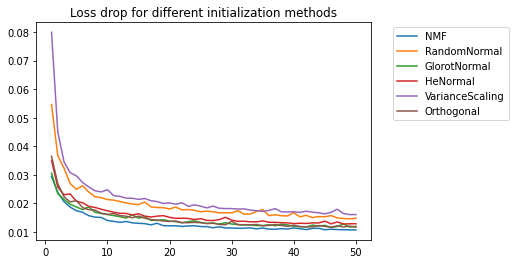

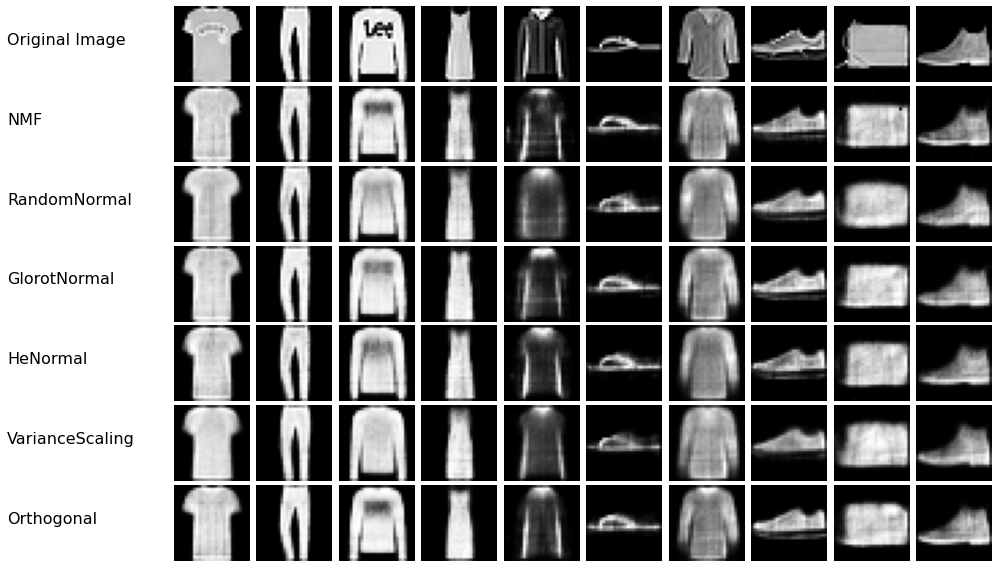

In [11]:
sample_size='all'
epochs = 50
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_fashion, x_train_fashion,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_fashion_loss_'+str(sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test_fashion)
    
display_images(x_test_fashion, decoded_imgs, selected_samples_fashion, image_type=methods, name='images/mnist_fashion_reconstruction_'+str(sample_size)+'_'+str(epochs))

# Train using all samples, fewer epochs

Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


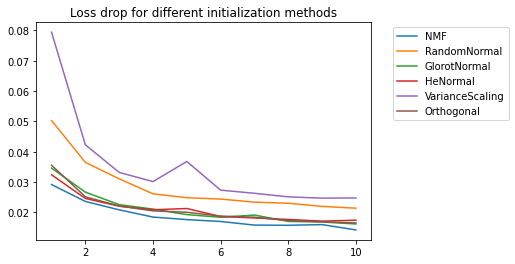

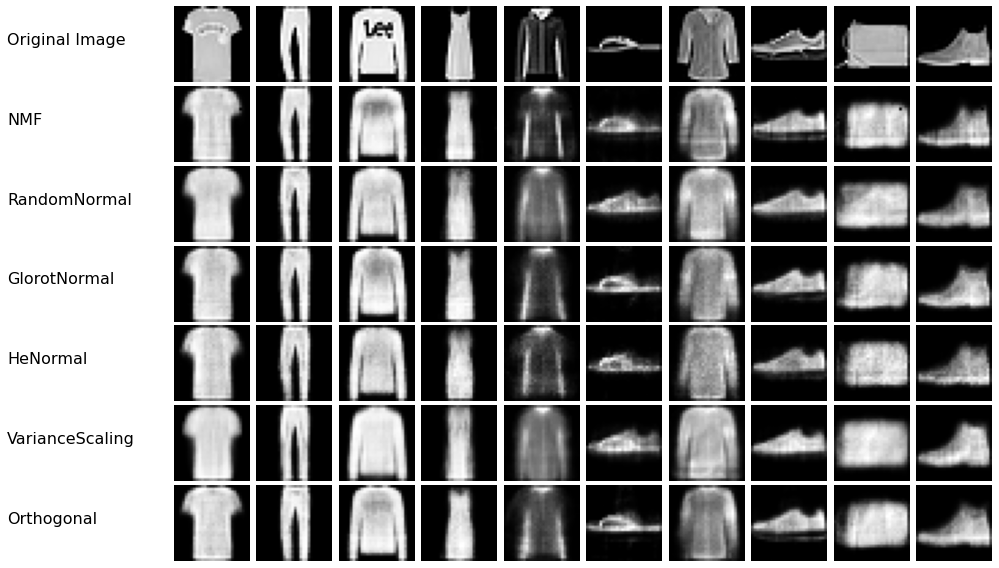

In [9]:
sample_size='all'
epochs = 10
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_fashion, x_train_fashion,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_fashion_loss_'+str(sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test_fashion)
    
display_images(x_test_fashion, decoded_imgs, selected_samples_fashion, image_type=methods, name='images/mnist_fashion_reconstruction_'+str(sample_size)+'_'+str(epochs))

# Train using fewer samples, 50 epochs

In [9]:
x_train_small_fashion = x_train_fashion[:small_sample_size, :]
y_train_small_fashion = y_train_fashion[:small_sample_size]
print(Counter(y_train_small_fashion))

Counter({1: 321, 3: 312, 7: 312, 4: 303, 5: 300, 6: 298, 9: 295, 2: 290, 8: 287, 0: 282})


Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


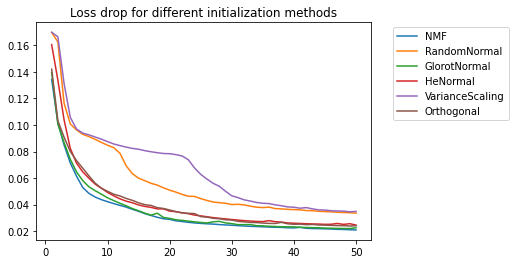

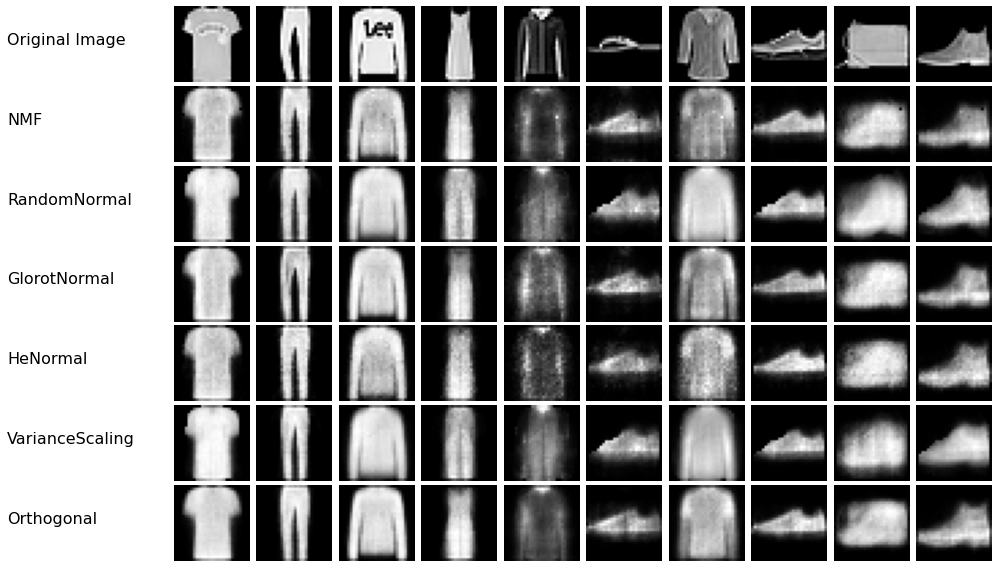

In [10]:
epochs = 50
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_small_fashion, x_train_small_fashion,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_fashion_loss_'+str(small_sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test_fashion)
    
display_images(x_test_fashion, decoded_imgs, selected_samples_fashion, image_type=methods, name='images/mnist_fashion_reconstruction_'+str(small_sample_size)+'_'+str(epochs))

# Train using fewer samples, fewer epochs

In [11]:
x_train_small_fashion = x_train_fashion[:small_sample_size, :]
y_train_small_fashion = y_train_fashion[:small_sample_size]
print(Counter(y_train_small_fashion))

Counter({1: 321, 3: 312, 7: 312, 4: 303, 5: 300, 6: 298, 9: 295, 2: 290, 8: 287, 0: 282})


Training the model with  NMF  initializer...
Training the model with  RandomNormal  initializer...
Training the model with  GlorotNormal  initializer...
Training the model with  HeNormal  initializer...
Training the model with  VarianceScaling  initializer...
Training the model with  Orthogonal  initializer...


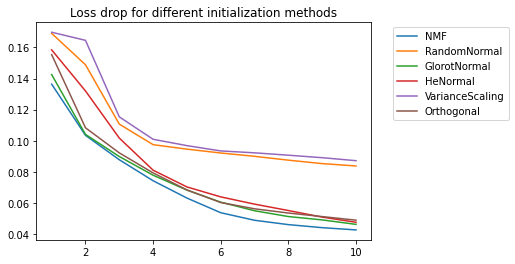

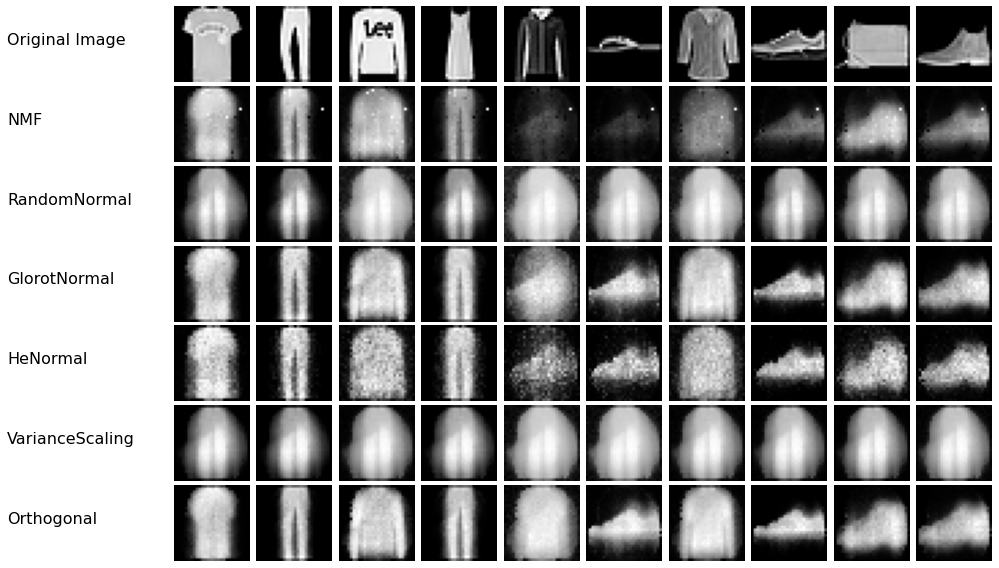

In [12]:
epochs = 10
autoencoders = {}
autoencoders['NMF'] = build_autoencoder(initializer='nmf')
autoencoders['RandomNormal'] = build_autoencoder(initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None))
autoencoders['GlorotNormal'] = build_autoencoder(initializer=tf.keras.initializers.GlorotNormal())
autoencoders['GlorotUniform'] = build_autoencoder(tf.keras.initializers.GlorotUniform())
autoencoders['HeNormal'] = build_autoencoder(initializer=tf.keras.initializers.HeNormal())
autoencoders['VarianceScaling'] = build_autoencoder(tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
autoencoders['Orthogonal'] = build_autoencoder(tf.keras.initializers.Orthogonal())


hist = {}
for init_method in methods:
    print("Training the model with ", init_method, " initializer...")
    hist[init_method] = History()
    autoencoders[init_method].fit(x_train_small_fashion, x_train_small_fashion,
                                  epochs=epochs,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.33,
                                  callbacks=[hist[init_method]],
                                  verbose=0)
    
display_loss(hist, name='images/mnist_fashion_loss_'+str(small_sample_size)+'_'+str(epochs), init_types=methods)

decoded_imgs = {}
for init_method in methods:
    decoded_imgs[init_method] = autoencoders[init_method].predict(x_test_fashion)
    
display_images(x_test_fashion, decoded_imgs, selected_samples_fashion, image_type=methods, name='images/mnist_fashion_reconstruction_'+str(small_sample_size)+'_'+str(epochs))